### Statistical Predictive Models

#### The task is to aggregate a dataset for a driver for a specific race and then design a timeseries forecast model to predict next 5 laps' lap times.

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
from scipy.stats import probplot
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import optuna

In [71]:
# Load the CSV files into DataFrames
lap_times_df = pd.read_csv('race_ts_updated/data_files/lap_times.csv')
pit_stops_df = pd.read_csv('race_ts_updated/data_files/pit_stops.csv')

In [72]:
# Input for this code is the driver_id and race_id
race_id = 931  # Example race ID for Brazilian Grand Prix 2022
driver_id = 817  # Example driver ID

In [73]:
def data_filtering(lap_times_df, pit_stops_df, race_id, driver_id):
    lap_times_df = lap_times_df[(lap_times_df['raceId'] == race_id) & (lap_times_df['driverId'] == driver_id)]
    pit_stops_df = pit_stops_df[(pit_stops_df['raceId'] == race_id) & (pit_stops_df['driverId'] == driver_id)]
    
    # Merge lap_times_df and pit_stops_df
    merged_df = pd.merge(lap_times_df, pit_stops_df, on=['raceId', 'driverId', 'lap'], how='left')

    # Calculate lap time difference
    merged_df['lapTimeDiff'] = merged_df['milliseconds_x'].diff()

    # Calculate rolling average lap time
    window_size = 5
    merged_df['rollingAvgLapTime'] = merged_df['milliseconds_x'].rolling(window=window_size).mean()

    # Create pit stop indicator
    merged_df['pitStopIndicator'] = merged_df['milliseconds_y'].notnull().astype(int)

    # Calculate pit stop duration
    merged_df['pitStopDuration'] = merged_df['milliseconds_y'].fillna(0) / 1000  # Convert to seconds

    # Calculate laps since last pit stop
    merged_df['lapsSinceLastPitStop'] = merged_df.groupby((merged_df['pitStopIndicator'] != merged_df['pitStopIndicator'].shift()).cumsum()).cumcount() + 1

    # Calculate rolling standard deviation of lap times
    merged_df['rollingStdLapTime'] = merged_df['milliseconds_x'].rolling(window=window_size).std()

    # Select relevant columns for the final dataset
    columns_to_select = ['raceId', 'driverId', 'lap', 'milliseconds_x', 'lapTimeDiff', 'rollingAvgLapTime',
                     'pitStopIndicator', 'pitStopDuration', 'lapsSinceLastPitStop', 'rollingStdLapTime']
    final_df = merged_df[columns_to_select].copy()

    # Rename columns
    column_renaming = {
    'milliseconds_x': 'lapTime',
    'milliseconds_y': 'pitStopTime'
    }

    final_df.rename(columns=column_renaming, inplace=True)

    # Handle missing values
    final_df.fillna(0, inplace=True)

    return final_df

In [74]:
def corr_plot(df):
    plt.figure(figsize=(6, 4))
    sns.heatmap(df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [75]:
def lag_plot(df):
    plt.figure(figsize=(10, 6))
    for i in range(1, 4):
        plt.subplot(2, 2, i)
        lag_plot(final_df['lapTime'], lag=i)
        plt.title(f'Lag {i}')
    plt.tight_layout()
    plt.show()

In [76]:
def visual_plot(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['lap'], df['lapTime'], c=df['pitStopIndicator'], cmap='viridis')
    plt.title('Lap Times with Pit Stops')
    plt.xlabel('Lap')
    plt.ylabel('Lap Time')
    plt.colorbar(label='Pit Stop Indicator')
    plt.show()

    #Scatterplot Matrix
    plt.figure(figsize=(12, 12))
    sns.pairplot(df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']])
    plt.title('Scatterplot Matrix of Relevant Variables')
    plt.show()

    # Box Plot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='pitStopIndicator', y='lapTime', data=df)
    plt.title('Box Plot of Lap Times by Pit Stop Occurrence')
    plt.xlabel('Pit Stop Indicator')
    plt.ylabel('Lap Time')
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(df['lap'], df['rollingAvgLapTime'], label='Rolling Average Lap Time')
    plt.plot(df['lap'], df['rollingStdLapTime'], label='Rolling Standard Deviation Lap Time')
    plt.title('Rolling Metrics')
    plt.xlabel('Lap')
    plt.ylabel('Lap Time')
    plt.legend()
    plt.show()

In [77]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    if result[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is non-stationary")

In [78]:
def ts_plots(df):
    # Visualize the time series variables
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.plot(df['lap'], df['lapTime'])
    plt.title('Lap Time')
    plt.xlabel('Lap')
    plt.ylabel('Time (ms)')

    plt.subplot(2, 3, 2)
    plt.plot(df['lap'], df['lapTimeDiff'])
    plt.title('Lap Time Difference')
    plt.xlabel('Lap')
    plt.ylabel('Time Difference (ms)')

    plt.subplot(2, 3, 3)
    plt.plot(df['lap'], df['rollingAvgLapTime'])
    plt.title('Rolling Average Lap Time')
    plt.xlabel('Lap')
    plt.ylabel('Time (ms)')

    plt.subplot(2, 3, 4)
    plt.plot(df['lap'], df['pitStopDuration'])
    plt.title('Pit Stop Duration')
    plt.xlabel('Lap')
    plt.ylabel('Duration (s)')

    plt.subplot(2, 3, 5)
    plt.plot(df['lap'], df['rollingStdLapTime'])
    plt.title('Rolling Standard Deviation of Lap Time')
    plt.xlabel('Lap')
    plt.ylabel('Standard Deviation (ms)')

    plt.tight_layout()
    plt.show()

In [79]:
def decom_plot(df):
    # Seasonal Decomposition Plot
    plt.figure(figsize=(12, 12))
    result = seasonal_decompose(df['lapTime'], model='additive', period=10)
    result.plot()
    plt.title('Seasonal Decomposition of Lap Times')
    plt.show()

In [80]:
def acf_pacf(df):
    #### Autocorrelation Function (ACF) Plot
    plt.figure(figsize=(10, 6))
    plot_acf(df['lapTime'], lags=15)
    plt.title('Autocorrelation Function (ACF) of Lap Times')
    plt.show()

    ## Partial Autocorrelation Function (PACF) Plot
    plt.figure(figsize=(10, 6))
    plot_pacf(df['lapTime'], lags=15)
    plt.title('Partial Autocorrelation Function (PACF) of Lap Times')
    plt.show()

In [81]:
def pacf_postprocessing(df):
    # Apply differencing to the 'rollingAvgLapTime' column
    df['rollingAvgLapTime_diff'] = df['rollingAvgLapTime'].diff()

    # Perform ADF test on the differenced 'rollingAvgLapTime' column
    print("ADF test for differenced rollingAvgLapTime:")
    adf_test(df['rollingAvgLapTime_diff'].dropna())
    return df

In [82]:
# Preprocess the data
# Normalize the features using min-max scaling
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

def denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Normalize the features
def data_preprocess(df):
    normalized_features = normalize(df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']])
    df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']] = normalized_features
    # Store the min and max values of the target variable for denormalization
    target_min = df['lapTime'].min()
    target_max = df['lapTime'].max()

    # Drop rows with missing values
    df.dropna(inplace=True)

    # Define the features and target variable
    features = ['lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']
    target = 'lapTime'

    # Split the data into training and testing sets
    train_size = len(df) - 5
    train_data = df[:train_size]
    test_data = df[train_size:]

    # Store the actual lap times of the test set
    Real_lap_times = test_data['lapTime'].values
    return train_data, test_data, target_min, target_max, features,target

In [83]:
# Create the ARIMA model
def create_arima_model(p, d, q, train_data,features,target):
    model = ARIMA(train_data[target], exog=train_data[features], order=(p, d, q))
    model_fit = model.fit()
    return model_fit

In [84]:
# Hyperparameter tuning
def tune_arima_model(train_data, test_data, target_min, target_max, features,target):
    best_params = None
    best_rmse = float('inf')
    Real_lap_times = test_data['lapTime'].values

    # Define the range of hyperparameters to search
    p_values = range(0, 3)
    d_values = range(0, 2)
    q_values = range(0, 3)

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = create_arima_model(p, d, q,train_data,features)
                    predictions = model.forecast(steps=5, exog=test_data[features])
                    rmse = sqrt(mean_squared_error(denormalize(test_data[target], target_min, target_max), denormalize(predictions, target_min, target_max)))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (p, d, q)
                except:
                    continue

    return best_params, best_rmse

In [85]:
def arima_pred(train_data, test_data, target_min, target_max, features,target):
    # Tune the ARIMA model
    best_params, best_rmse = tune_arima_model(train_data, test_data, target_min, target_max, features,target)

    if best_params is None:
        print("No suitable hyperparameters found. Using default values.")
        best_params = (1, 1, 1)  # Default hyperparameters

    print("Best hyperparameters: ", best_params)
    # Train the ARIMA model with the best hyperparameters
    best_model = create_arima_model(*best_params,train_data,features,target)

    # Make predictions on the test data
    predictions = best_model.forecast(steps=5, exog=test_data[features])

    # Denormalize the predicted lap times
    predicted_lap_times_arima = denormalize(predictions, target_min, target_max)

    # Denormalize the actual lap times
    actual_lap_times_arima = denormalize(test_data[target], target_min, target_max)

    # Create a DataFrame with predicted lap times and corresponding lap numbers
    predicted_df = pd.DataFrame({'lap': test_data.index, 'predicted_lapTime': predicted_lap_times_arima})
    Real_lap_times = test_data['lapTime'].values

    # Evaluate the model
    rmse_arima = sqrt(mean_squared_error(Real_lap_times, predicted_lap_times_arima))
    mae_arima = mean_absolute_error(Real_lap_times, predicted_lap_times_arima)

    print("Test RMSE: ", rmse_arima)
    print("Test MAE: ", mae_arima)

    # Generate predictions on the test data
    predictions = best_model.forecast(steps=len(test_data), exog=test_data[features])

    # Calculate the residuals
    residuals = test_data[target] - predictions

    return best_model, predictions, residuals, rmse_arima, mae_arima, predicted_lap_times_arima

In [86]:
def forecast_errors_arima(best_model, test_data, features, target, predictions):
    forecast_errors = []
    for horizon in range(1, 6):
        predictions = best_model.forecast(steps=horizon, exog=test_data[features][:horizon])
        rmse = np.sqrt(mean_squared_error(test_data[target][:horizon], predictions))
        mae = mean_absolute_error(test_data[target][:horizon], predictions)
        forecast_errors.append({'Horizon': horizon, 'RMSE': rmse, 'MAE': mae})
    forecast_errors_df = pd.DataFrame(forecast_errors)
    return forecast_errors_df

In [87]:
def model_plots(test_data,predicted_lap_times_arima, residuals, features, target, forecast_errors_df, arima=False):
    Real_lap_times = test_data['lapTime'].values
    plt.figure(figsize=(8, 4))
    plt.plot(test_data['lap'], Real_lap_times, label='Actual')
    plt.plot(test_data['lap'], predicted_lap_times_arima, label='Predicted')
    if arima is False:
        plt.title('Actual vs. Predicted Lap Times (ARIMA)')
    else:
        plt.title('Actual vs. Predicted Lap Times (LSTM)')
    plt.xlabel('Lap')
    plt.ylabel('Lap Time')
    plt.legend()
    plt.show()

    # Residual Plot
    plt.figure(figsize=(8, 4))
    plt.scatter(range(len(residuals)), residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    if arima is False:
        plt.title('Residual Plot - ARIMA Model')
    else:
        plt.title('Residual Plot - LSTM Model')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.show()

    # CUSUM Chart
    plt.figure(figsize=(8, 4))
    cum_residuals = np.cumsum(residuals)
    plt.plot(cum_residuals)
    if arima is False:
        plt.title('CUSUM Plot - ARIMA Model')
    else:
        plt.title('CUSUM Plot - LSTM Model')
    plt.xlabel('Index')
    plt.ylabel('Cumulative Sum of Residuals')
    plt.show()

    # Q-Q Plot
    plt.figure(figsize=(8, 4))
    probplot(residuals, plot=plt)
    if arima is False:
        plt.title('Q-Q Plot - ARIMA Model')
    else:
        plt.title('Q-Q Plot - LSTM Model')
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['RMSE'], marker='o', label='RMSE')
    plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['MAE'], marker='o', label='MAE')
    if arima is False:
        plt.title('Forecast Error Metrics - ARIMA Model')
    else:
        plt.title('Forecast Error Metrics - LSTM Model')
    plt.xlabel('Forecast Horizon')
    plt.ylabel('Error Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

In [88]:
#Choosing specific race and driver
race_id = 1095  # Example race ID for Brazilian Grand Prix 2022
driver_id = 1  # Example driver ID

In [89]:
def arima_run(race_id, driver_id):
    final_df = data_filtering(lap_times_df, pit_stops_df, race_id, driver_id)
    corr = corr_plot(final_df)
    #lags = lag_plot(final_df)
    descriptive = visual_plot(final_df)
    var_plots = ts_plots(final_df)
    decompose = decom_plot(final_df)
    acf_check = acf_pacf(final_df)

    # Perform ADF test on the time series variables
    adf_list = ['lapTime','lapTimeDiff','rollingAvgLapTime','pitStopDuration','rollingStdLapTime']
    for columns in adf_list:
        print('ADF test for ' + columns)
        adf_test(final_df[columns])
    df_final = pacf_postprocessing(final_df)
    train_data, test_data, target_min, target_max, features,target = data_preprocess(df_final)
    best_model, predictions, residuals, rmse_arima, mae_arima, predicted_lap_times_arima = arima_pred(train_data, test_data, 
                                                                                                  target_min, target_max, features,target)
    forecast_errors_df = forecast_errors_arima(best_model, test_data, features, target, predictions)
    arima_visuals = model_plots(test_data,predicted_lap_times_arima, residuals, features, target, forecast_errors_df, arima=False)
    return rmse_arima, mae_arima

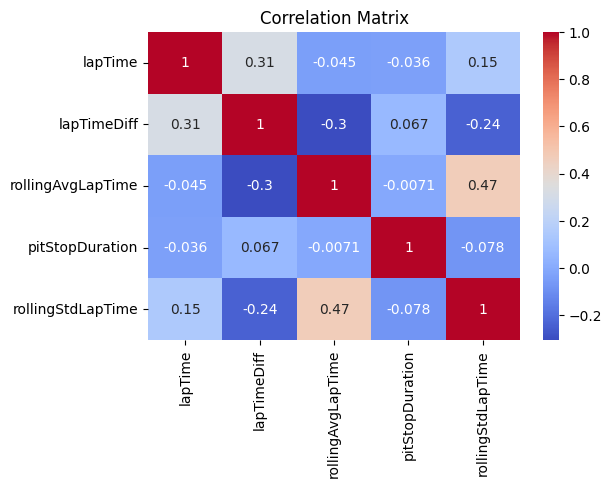

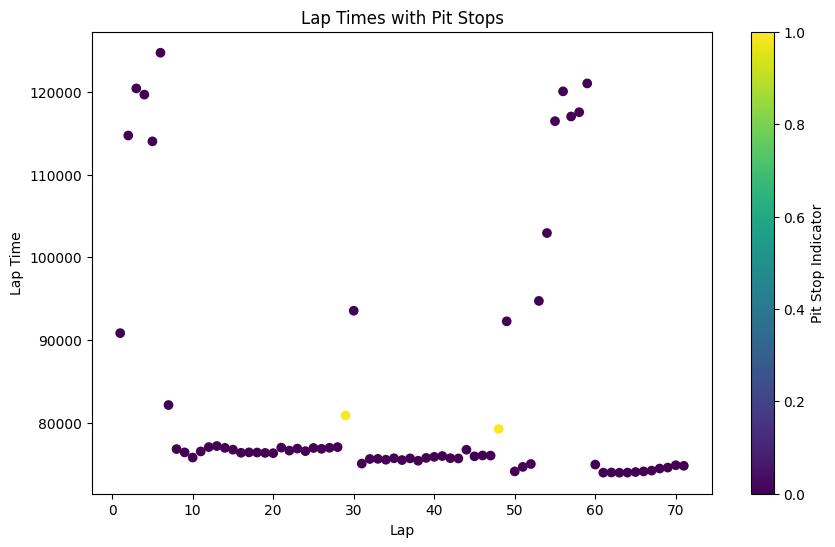

<Figure size 1200x1200 with 0 Axes>

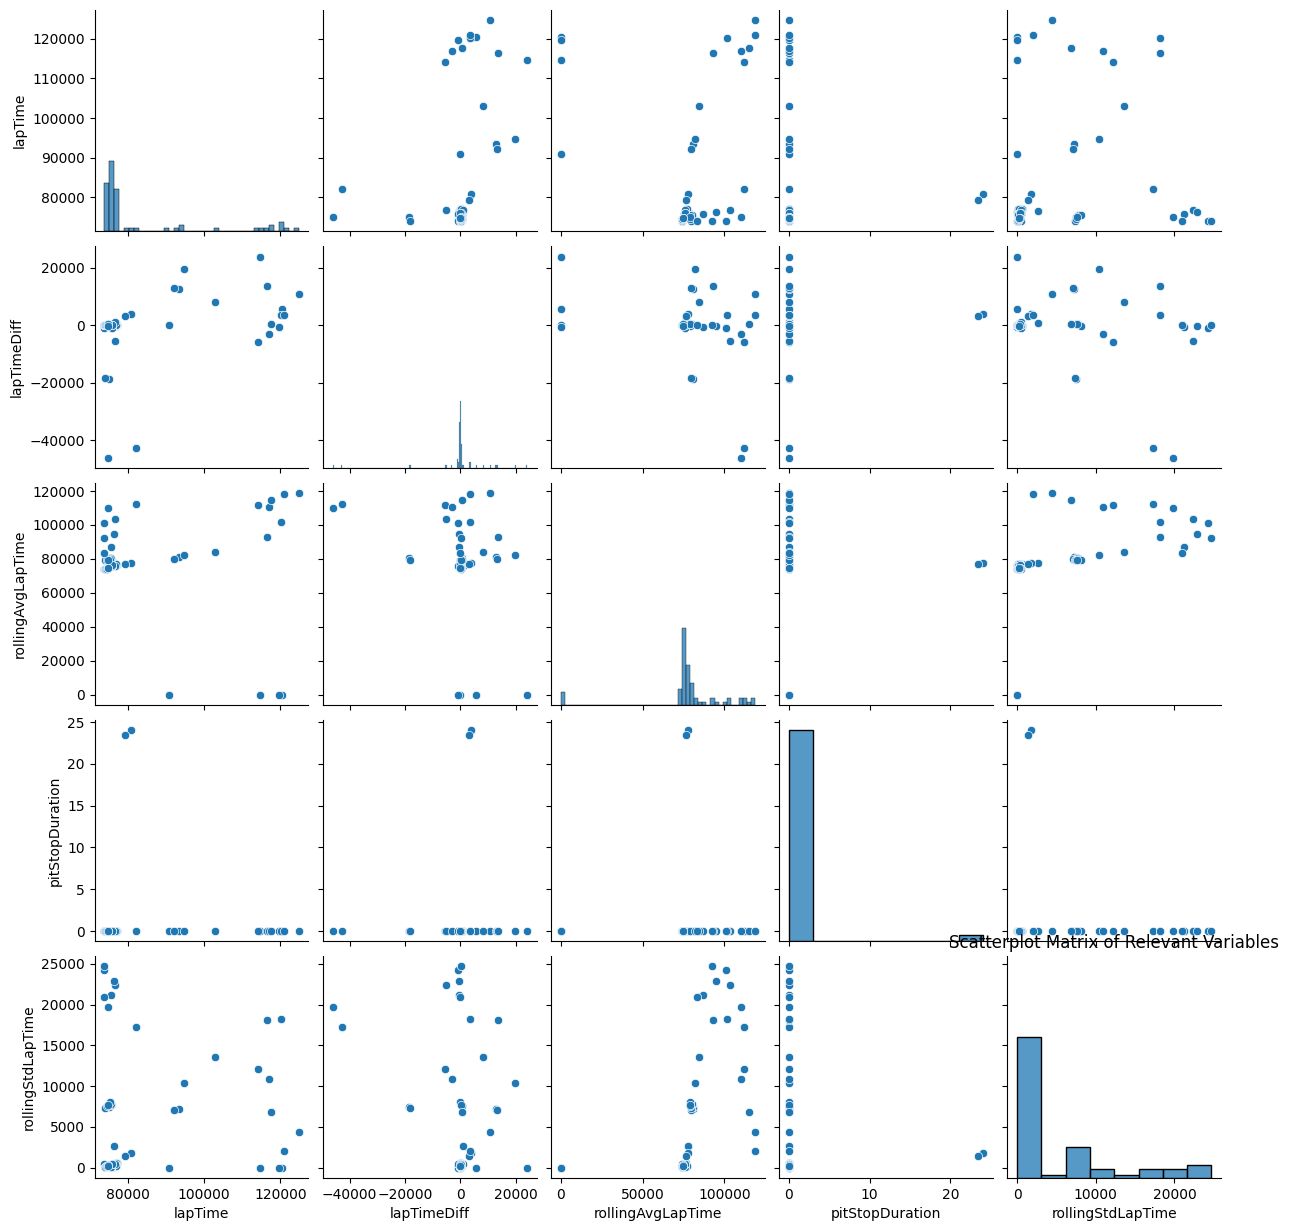

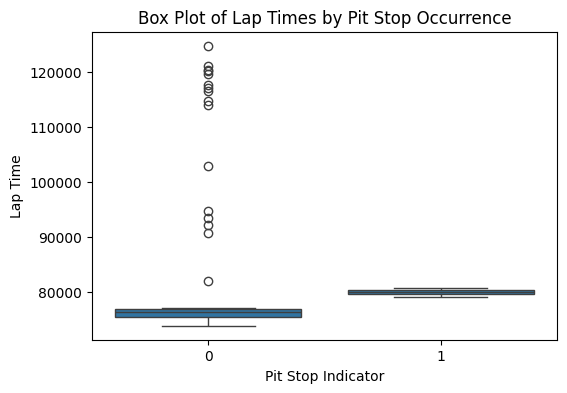

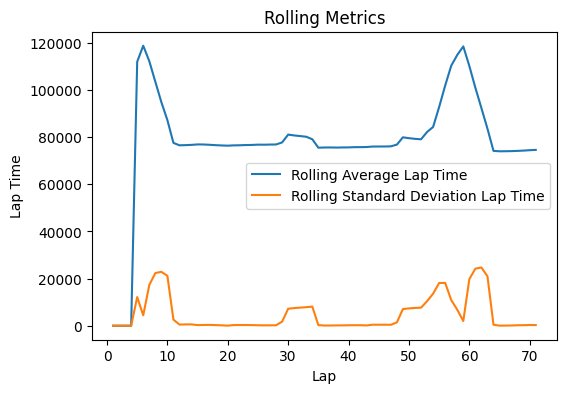

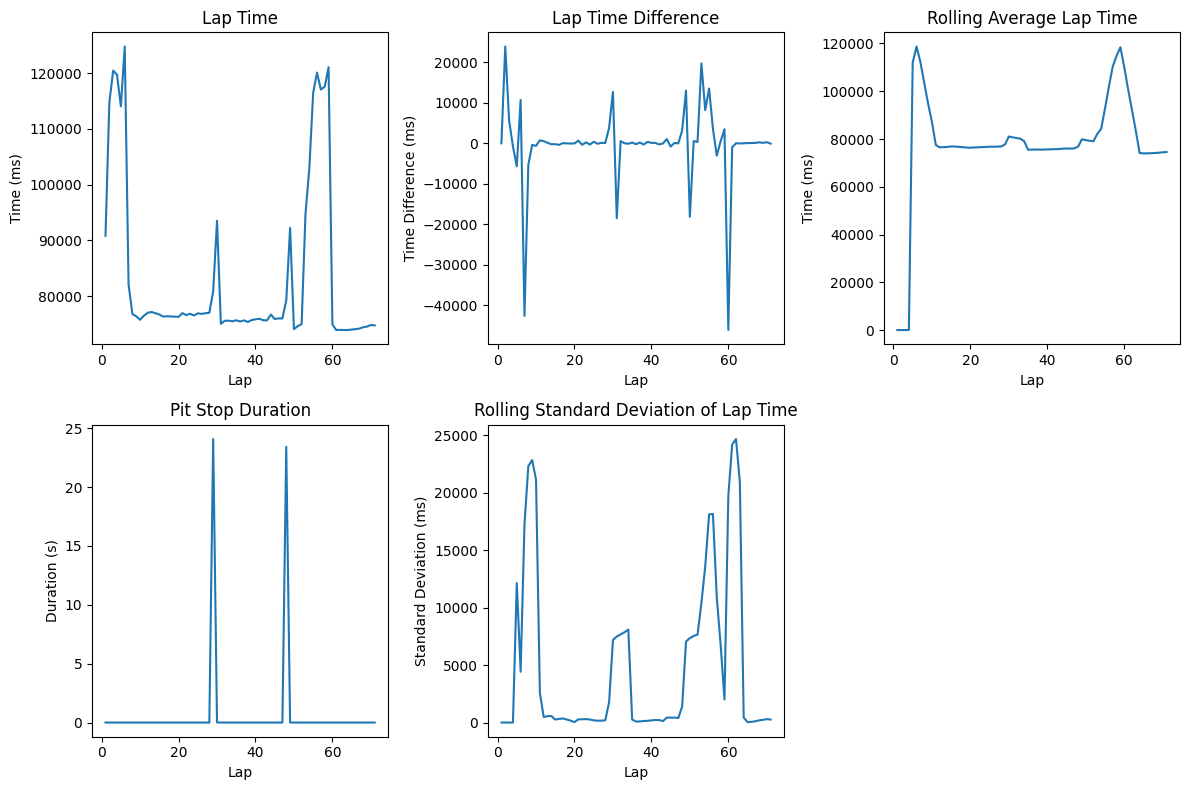

<Figure size 1200x1200 with 0 Axes>

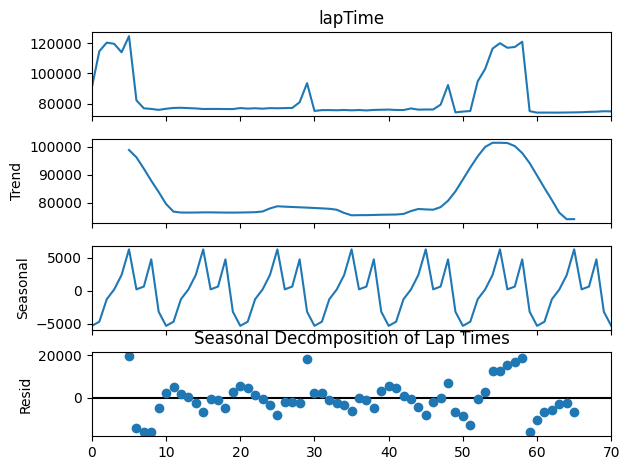

<Figure size 1000x600 with 0 Axes>

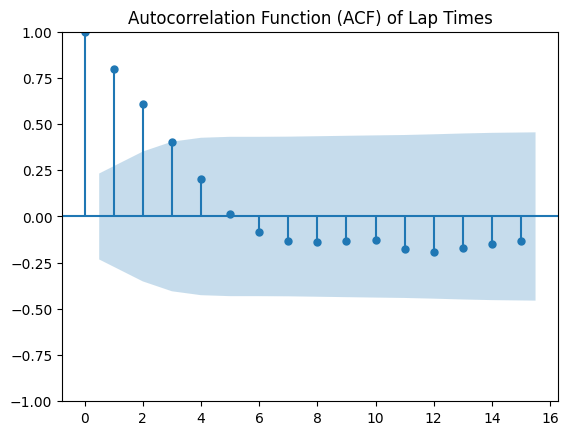

<Figure size 1000x600 with 0 Axes>

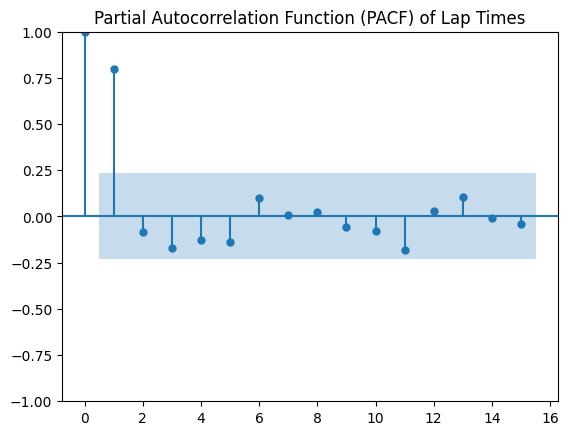

ADF test for lapTime
ADF Statistic: -2.714377803126345
p-value: 0.07158315540711024
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
The series is non-stationary
ADF test for lapTimeDiff
ADF Statistic: -8.714618860130022
p-value: 3.5156322721977496e-14
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
The series is stationary
ADF test for rollingAvgLapTime
ADF Statistic: -2.3867536786900425
p-value: 0.14551004096109643
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591
The series is non-stationary
ADF test for pitStopDuration
ADF Statistic: -8.49237027363759
p-value: 1.3030072790881107e-13
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
The series is stationary
ADF test for rollingStdLapTime
ADF Statistic: -2.8274857163984026
p-value: 0.054453620428122275
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591
The series is non-stationary
ADF test for differenced rollingAvgLapTime:
ADF Statistic: -4.58695975033289
p-value: 0.00013651027117930688
Critical Values:
	1%: -3

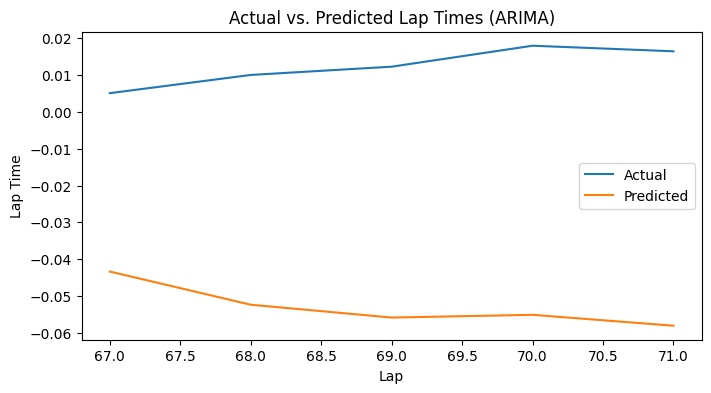

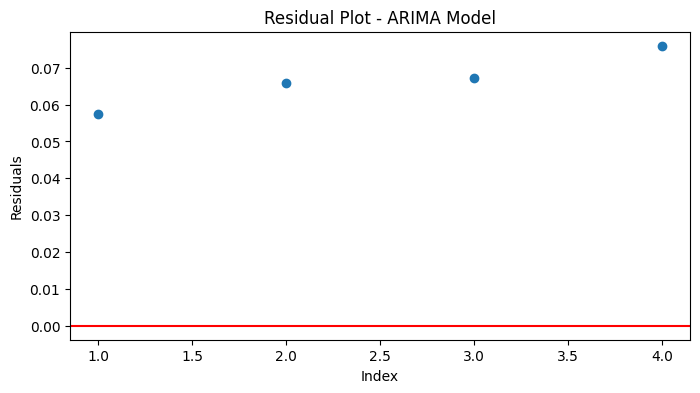

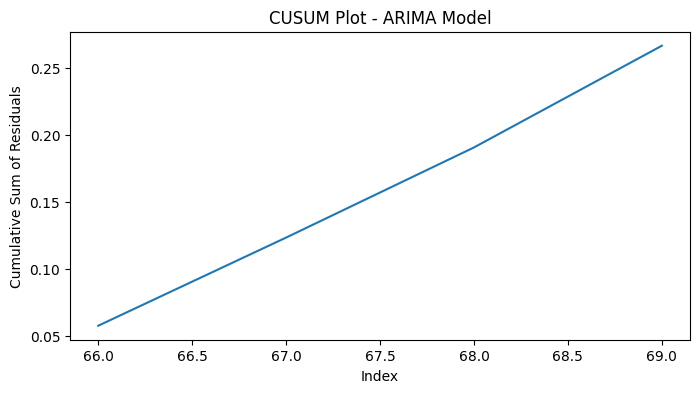

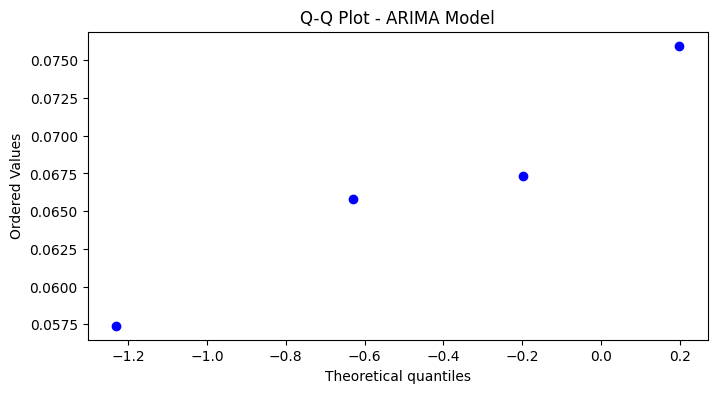

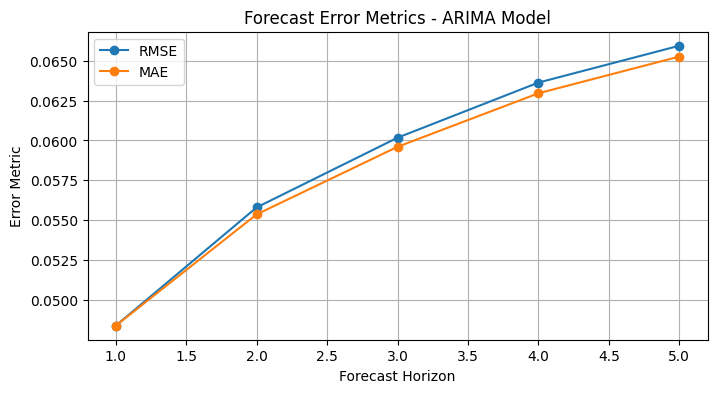

In [90]:
rmse_arima, mae_arima = arima_run(race_id, driver_id)

## LSTM (Long Short Term Memory)

In [91]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import optuna

In [92]:
df = data_filtering(lap_times_df, pit_stops_df, race_id, driver_id)
train_data, test_data, target_min, target_max, features,target = data_preprocess(df)

In [93]:
# Create a function to prepare the data for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 4):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+5]['lapTime'].values)
    return np.array(X), np.array(y)

In [94]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [95]:
# Hyperparameter tuning
def tune_window_size(window_sizes):
    best_window_size = None
    best_rmse = float('inf')

    for window_size in window_sizes:
        # Prepare the data
        X, y = create_sequences(df[features + [target]], window_size)
        train_size = len(X) - 5
        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:], y[train_size:]

        # Create the LSTM model
        input_dim = X_train.shape[2]
        output_dim = 5
        hidden_dim = 64
        num_layers = 2
        model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

        # Train the LSTM model
        num_epochs = 100
        batch_size = 32
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            for i in range(0, len(X_train), batch_size):
                batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        # Make predictions on the test data
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            predictions = model(X_test_tensor)
            predicted_lap_times = denormalize(predictions.numpy(), target_min, target_max)
            actual_lap_times = denormalize(y_test, target_min, target_max)

            rmse = sqrt(mean_squared_error(actual_lap_times, predicted_lap_times))
            if rmse < best_rmse:
                best_rmse = rmse
                best_window_size = window_size

    return best_window_size, best_rmse

In [96]:
def lstm_training(best_window_size, best_rmse,test):
    # Tune the window size
    print("Best window size: ", best_window_size)
    print("Best RMSE: ", best_rmse)

    # Train the LSTM model with the best window size
    X, y = create_sequences(df[features + [target]], best_window_size)
    train_size = len(X) - 5
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    input_dim = X_train.shape[2]
    output_dim = 5
    hidden_dim = 64
    num_layers = 2
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

    num_epochs = 100
    batch_size = 32
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
            batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    torch.save(model.state_dict(),'lstm_nontuned_d1.pth')

    # Make predictions on the test data
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        predictions = model(X_test_tensor)
        predicted_lap_times = denormalize(predictions.numpy(), target_min, target_max)
        actual_lap_times = denormalize(y_test, target_min, target_max)
        Real_lap_times = test['lapTime'].values
        rmse_lstm = sqrt(mean_squared_error(Real_lap_times, predicted_lap_times[0]))
        mae_lstm = mean_absolute_error(Real_lap_times, predicted_lap_times[0])

    print("Test RMSE: ", rmse_lstm)
    print("Test MAE: ", mae_lstm)

    # Calculate the residuals
    residuals = actual_lap_times - predicted_lap_times

    # Reshape the residuals to have a 1D shape
    residuals = residuals.reshape(-1)

    return predicted_lap_times,actual_lap_times, residuals, rmse_lstm, mae_lstm

In [97]:
# Forecast Error Metrics Plot
def forecast_lstm(predicted_lap_times,actual_lap_times):
    forecast_errors = []
    for horizon in range(1, 6):
        predicted_lap_times_horizon = predicted_lap_times[:, :horizon]
        actual_lap_times_horizon = actual_lap_times[:, :horizon]
        rmse = np.sqrt(mean_squared_error(actual_lap_times_horizon, predicted_lap_times_horizon))
        mae = mean_absolute_error(actual_lap_times_horizon, predicted_lap_times_horizon)
        mape = np.mean(np.abs((actual_lap_times_horizon - predicted_lap_times_horizon) / actual_lap_times_horizon)) * 100
        forecast_errors.append({'Horizon': horizon, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

    forecast_errors_df = pd.DataFrame(forecast_errors)
    return forecast_errors_df

In [98]:
def lstm_run(race_id, driver_id):
    df = data_filtering(lap_times_df, pit_stops_df, race_id, driver_id)
    train_data, test_data, target_min, target_max, features,target = data_preprocess(df)
    best_window_size, best_rmse = tune_window_size(window_sizes = [5, 10, 15, 20])
    predicted_lap_times,actual_lap_times, residuals, rmse_lstm, mae_lstm = lstm_training(best_window_size, best_rmse, test)
    forecast_errors_df = forecast_lstm(predicted_lap_times,actual_lap_times)
    lstm_visuals = model_plots(test_data,predicted_lap_times[0], residuals, features, target, forecast_errors_df, arima=True)
    return rmse_lstm, mae_lstm

Best window size:  10
Best RMSE:  0.05594225364605649
Test RMSE:  0.02674416164148849
Test MAE:  0.021663065039723407


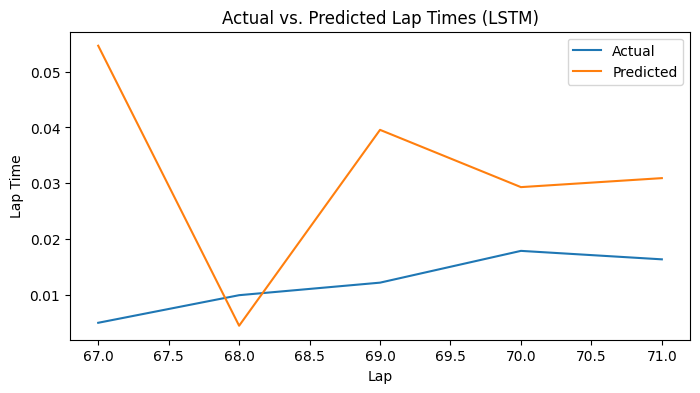

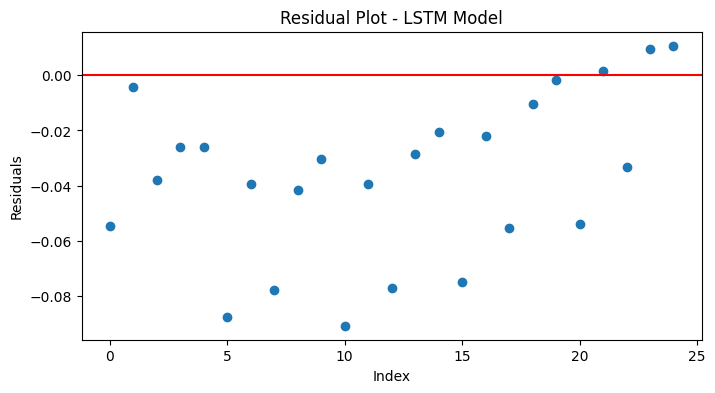

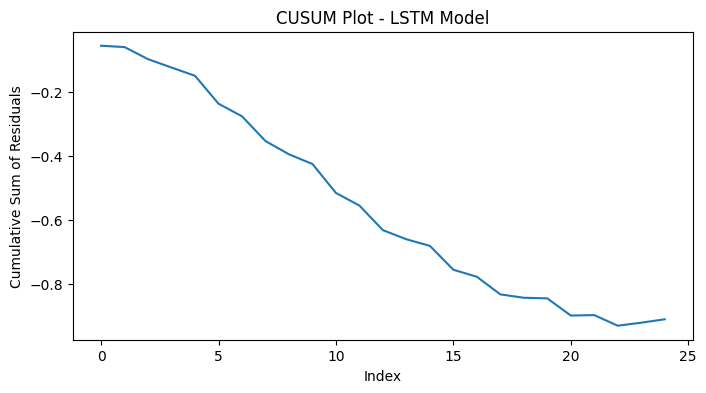

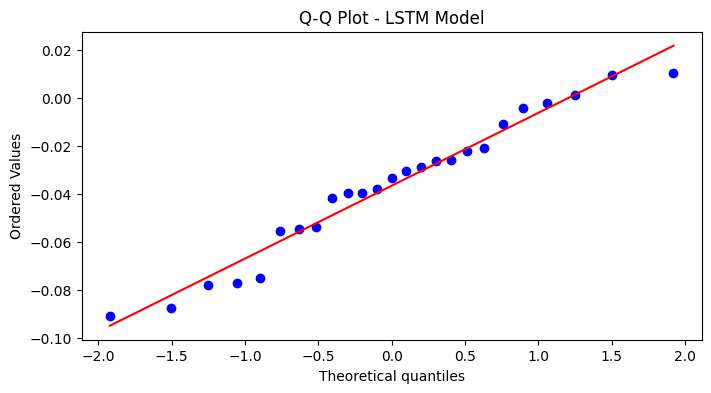

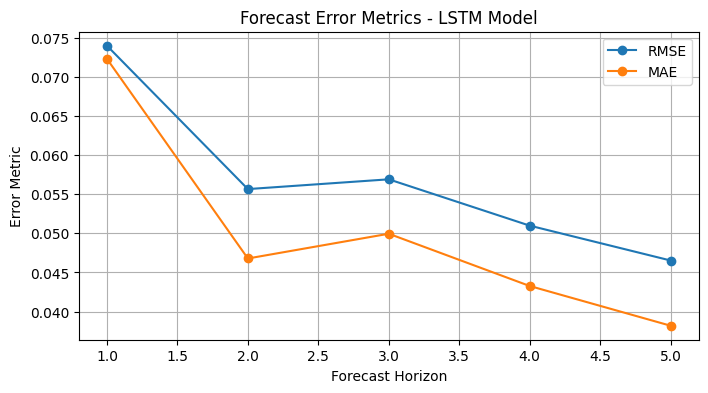

In [117]:
rmse_lstm, mae_lstm = lstm_run(race_id, driver_id)

#  Optuna for hyperparameter tuning

[I 2024-05-30 13:45:06,900] A new study created in memory with name: no-name-a1c6bfa3-3e86-44b9-9c30-f4a5ac512357
[I 2024-05-30 13:45:23,326] Trial 0 finished with value: 0.08015524391657916 and parameters: {'window_size': 18, 'hidden_dim': 228, 'num_layers': 3, 'lr': 0.0006072598998475746}. Best is trial 0 with value: 0.08015524391657916.
[I 2024-05-30 13:45:31,050] Trial 1 finished with value: 0.09090045959117234 and parameters: {'window_size': 29, 'hidden_dim': 102, 'num_layers': 2, 'lr': 0.00013195968840401862}. Best is trial 0 with value: 0.08015524391657916.
[I 2024-05-30 13:45:51,626] Trial 2 finished with value: 0.03095097441862876 and parameters: {'window_size': 29, 'hidden_dim': 209, 'num_layers': 4, 'lr': 0.00016596350492152216}. Best is trial 2 with value: 0.03095097441862876.
[I 2024-05-30 13:46:05,764] Trial 3 finished with value: 0.7286034889702414 and parameters: {'window_size': 29, 'hidden_dim': 206, 'num_layers': 3, 'lr': 0.006106159204314353}. Best is trial 2 with va

Best hyperparameters:
Window size: 26
Hidden dimension: 68
Number of layers: 4
Learning rate: 0.0021133407987863014
Best RMSE: 0.021237663305160744


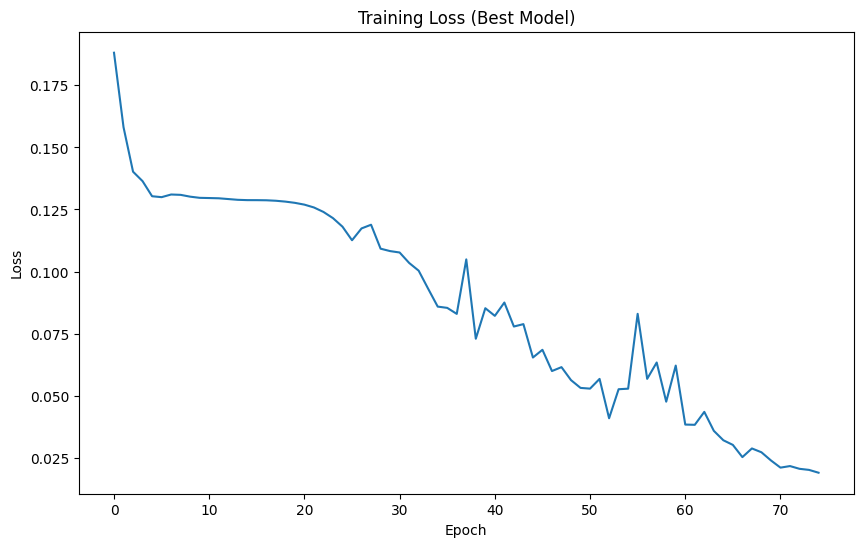

In [100]:
# Load the prepared dataset
df = data_filtering(lap_times_df, pit_stops_df, race_id, driver_id)
train_data, test_data, target_min, target_max, features,target = data_preprocess(df)

# Create a function to prepare the data for LSTM
def create_sequences(data, window_size):
   X, y = [], []
   for i in range(len(data) - window_size - 4):
       X.append(data[i:i+window_size])
       y.append(data[i+window_size:i+window_size+5]['lapTime'].values)
   return np.array(X), np.array(y)

# Define the LSTM model
class LSTMModel(nn.Module):
   def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim
       self.num_layers = num_layers
       self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
       self.fc = nn.Linear(hidden_dim, output_dim)

   def forward(self, x):
       h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
       c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
       out, _ = self.lstm(x, (h0.detach(), c0.detach()))
       out = self.fc(out[:, -1, :])
       return out

# Optuna hyperparameter tuning
def objective(trial):
   window_size = trial.suggest_int('window_size', 5, 30)
   hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
   num_layers = trial.suggest_int('num_layers', 1, 4)
   lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

   # Prepare the data
   X, y = create_sequences(df[features + [target]], window_size)
   train_size = len(X) - 5
   X_train, y_train = X[:train_size], y[:train_size]
   X_test, y_test = X[train_size:], y[train_size:]

   # Create the LSTM model
   input_dim = X_train.shape[2]
   output_dim = 5
   model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

   # Train the LSTM model
   num_epochs = 75
   batch_size = 32
   criterion = nn.MSELoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=lr)

   for epoch in range(num_epochs):
       epoch_loss = 0
       for i in range(0, len(X_train), batch_size):
           batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
           batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

           optimizer.zero_grad()
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           loss.backward()
           optimizer.step()
           epoch_loss += loss.item()

   # Make predictions on the test data
   with torch.no_grad():
       X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
       predictions = model(X_test_tensor)
       predicted_lap_times = denormalize(predictions.numpy(), target_min, target_max)
       actual_lap_times = denormalize(y_test, target_min, target_max)

       rmse = sqrt(mean_squared_error(actual_lap_times, predicted_lap_times))

   return rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding RMSE
print("Best hyperparameters:")
print("Window size:", study.best_params['window_size'])
print("Hidden dimension:", study.best_params['hidden_dim'])
print("Number of layers:", study.best_params['num_layers'])
print("Learning rate:", study.best_params['lr'])
print("Best RMSE:", study.best_value)

# Train the LSTM model with the best hyperparameters
best_window_size = study.best_params['window_size']
best_hidden_dim = study.best_params['hidden_dim']
best_num_layers = study.best_params['num_layers']
best_lr = study.best_params['lr']

X, y = create_sequences(df[features + [target]], best_window_size)
train_size = len(X) - 5
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

input_dim = X_train.shape[2]
output_dim = 5
model = LSTMModel(input_dim, best_hidden_dim, best_num_layers, output_dim)

num_epochs = 75
batch_size = 32
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

train_losses = []
for epoch in range(num_epochs):
   epoch_loss = 0
   for i in range(0, len(X_train), batch_size):
       batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
       batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       loss.backward()
       optimizer.step()
    
       epoch_loss += loss.item()
   train_losses.append(epoch_loss / (len(X_train) / batch_size))

# Plot the training loss for the best model
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [104]:
# Make predictions on the test data
with torch.no_grad():
   X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
   predictions = model(X_test_tensor)
   predicted_lap_times_optuna = denormalize(predictions.numpy(), target_min, target_max)
   actual_lap_times_optuna = denormalize(y_test, target_min, target_max)

   rmse_lstm_tuned = sqrt(mean_squared_error(actual_lap_times_optuna[0], predicted_lap_times_optuna[0]))
   mae_lstm_tuned = mean_absolute_error(actual_lap_times_optuna[0], predicted_lap_times_optuna[0])

print("Test RMSE LSTM Tuned: ", rmse_lstm_tuned)
print("Test MAE LSTM Tuned: ", mae_lstm_tuned)

Test RMSE LSTM Tuned:  0.025582997132106117
Test MAE LSTM Tuned:  0.02308158995238597


In [105]:
torch.save(model.state_dict(), 'lstm_tuned_d1.pth')

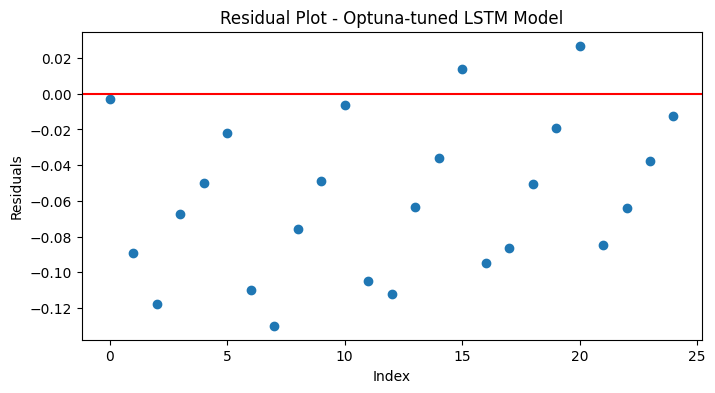

In [106]:
# Calculate the residuals
residuals = actual_lap_times - predicted_lap_times

# Reshape the residuals to have a 1D shape
residuals = residuals.reshape(-1)

# Residual Plot
plt.figure(figsize=(8, 4))
plt.scatter(range(len(residuals)), residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot - Optuna-tuned LSTM Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

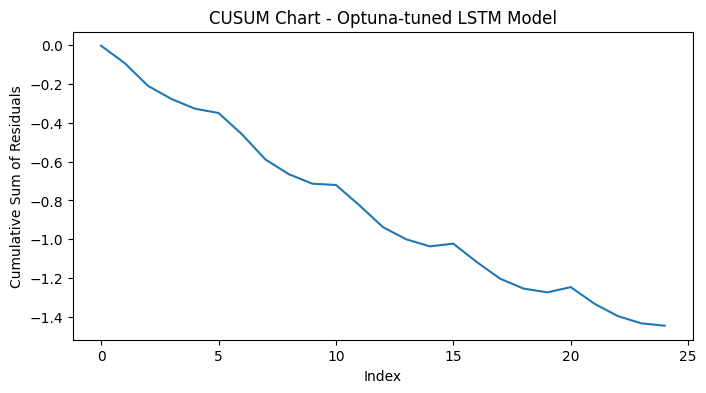

In [107]:
# CUSUM Chart
plt.figure(figsize=(8, 4))
cum_residuals = np.cumsum(residuals)
plt.plot(cum_residuals)
plt.title('CUSUM Chart - Optuna-tuned LSTM Model')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum of Residuals')
plt.show()

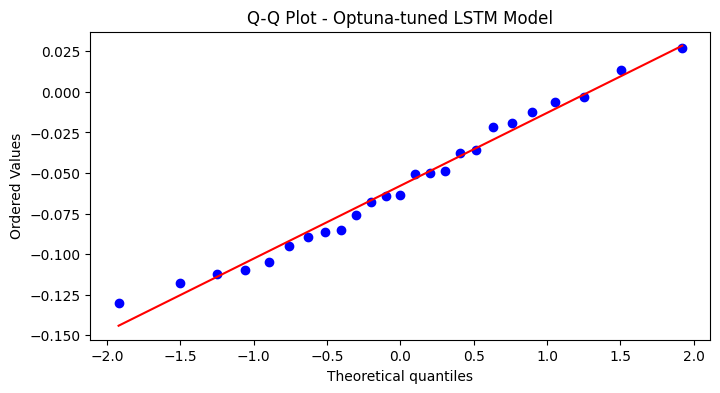

In [108]:
# Q-Q Plot
plt.figure(figsize=(8, 4))
probplot(residuals, plot=plt)
plt.title('Q-Q Plot - Optuna-tuned LSTM Model')
plt.show()

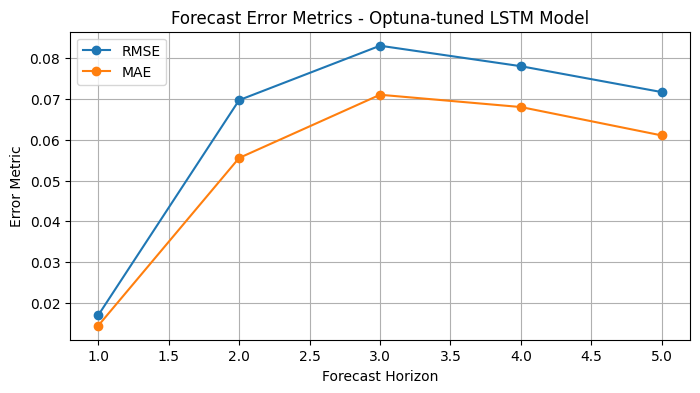

In [109]:
# Forecast Error Metrics Plot
# Calculate forecast errors for different horizons
forecast_errors = []
for horizon in range(1, 6):
    predicted_lap_times_horizon = predicted_lap_times[:, :horizon]
    actual_lap_times_horizon = actual_lap_times[:, :horizon]
    rmse = np.sqrt(mean_squared_error(actual_lap_times_horizon, predicted_lap_times_horizon))
    mae = mean_absolute_error(actual_lap_times_horizon, predicted_lap_times_horizon)
    mape = np.mean(np.abs((actual_lap_times_horizon - predicted_lap_times_horizon) / actual_lap_times_horizon)) * 100
    forecast_errors.append({'Horizon': horizon, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

forecast_errors_df = pd.DataFrame(forecast_errors)

plt.figure(figsize=(8, 4))
plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['RMSE'], marker='o', label='RMSE')
plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['MAE'], marker='o', label='MAE')
plt.title('Forecast Error Metrics - Optuna-tuned LSTM Model')
plt.xlabel('Forecast Horizon')
plt.ylabel('Error Metric')
plt.legend()
plt.grid(True)
plt.show()

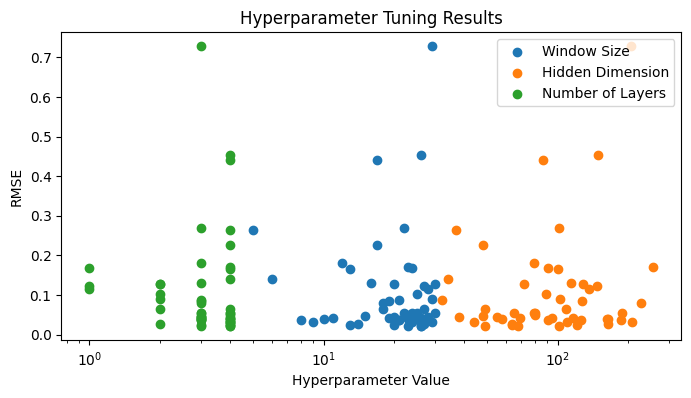

In [110]:
plt.figure(figsize=(8, 4))
plt.scatter(study.trials_dataframe()['params_window_size'], study.trials_dataframe()['value'], label='Window Size')
plt.scatter(study.trials_dataframe()['params_hidden_dim'], study.trials_dataframe()['value'], label='Hidden Dimension')
plt.scatter(study.trials_dataframe()['params_num_layers'], study.trials_dataframe()['value'], label='Number of Layers')
plt.xscale('log')
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Hyperparameter Value')
plt.ylabel('RMSE')
plt.legend()
plt.show()

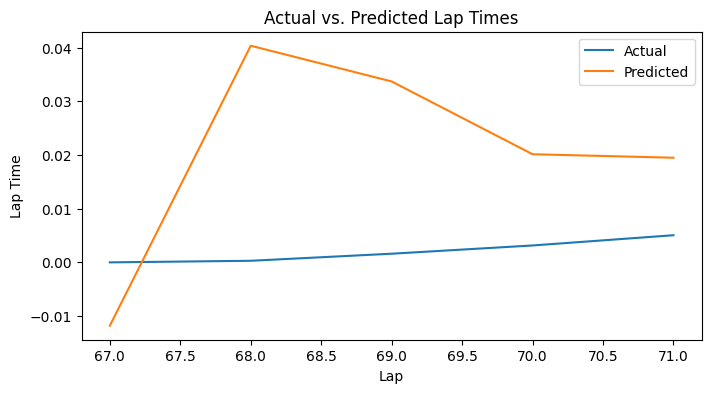

In [112]:
plt.figure(figsize=(8, 4))
plt.plot(test_data['lap'], actual_lap_times_optuna[0], label='Actual')
plt.plot(test_data['lap'], predicted_lap_times_optuna[0], label='Predicted')
plt.title('Actual vs. Predicted Lap Times')
plt.xlabel('Lap')
plt.ylabel('Lap Time')
plt.legend()
plt.show()

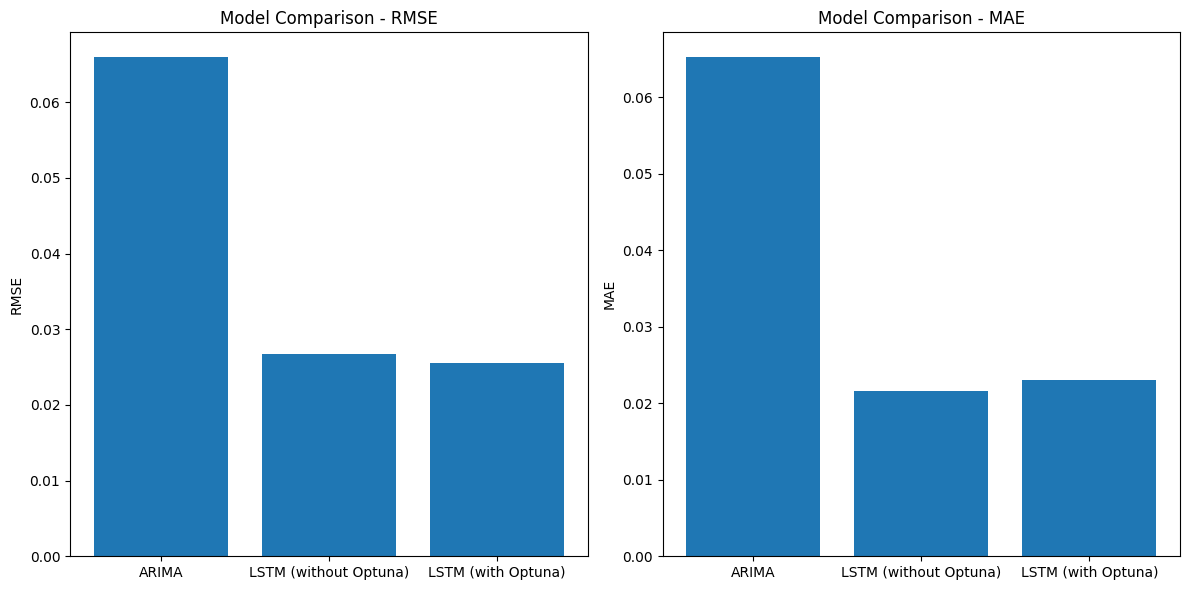

Final Results:
ARIMA Test RMSE:  0.06593115952605637
ARIMA Test MAE:  0.06525238819195234
LSTM (without Optuna) Test RMSE:  0.02674416164148849
LSTM (without Optuna) Test MAE:  0.021663065039723407
LSTM (with Optuna) Test RMSE:  0.025582997132106117
LSTM (with Optuna) Test MAE:  0.02308158995238597


In [118]:
# Model Comparison Plot
models = ['ARIMA', 'LSTM (without Optuna)', 'LSTM (with Optuna)']
rmse_values = [rmse_arima, rmse_lstm, rmse_lstm_tuned]
mae_values = [mae_arima, mae_lstm, mae_lstm_tuned]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values)
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.bar(models, mae_values)
plt.title('Model Comparison - MAE')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

# Save the trained models
torch.save(model.state_dict(), 'lstm_model.pth')
torch.save(study.best_params, 'lstm_tuned_params.pth')

# Print the final results and insights
print("Final Results:")
print("ARIMA Test RMSE: ", rmse_arima)
print("ARIMA Test MAE: ", mae_arima)
print("LSTM (without Optuna) Test RMSE: ", rmse_lstm)
print("LSTM (without Optuna) Test MAE: ", mae_lstm)
print("LSTM (with Optuna) Test RMSE: ", rmse_lstm_tuned)
print("LSTM (with Optuna) Test MAE: ", mae_lstm_tuned)

#### Main techniques used in forecasting:

1. Stationarity checking- Stationarity checks were conducted using the Augmented Dickey-Fuller test to ensure the time series variables met the required assumptions. Any non-stationarity was addressed through differencing.
2. Logical feature elimination-Irrelevant features were logically eliminated from the initial dataset by removing columns that did not vary with changing lap numbers or provide useful information about lap times. This pruning ensured the final dataset contained only relevant predictors.
3. Feature engineering- New variables like lap time differences, rolling averages, and rolling standard deviations were created to capture trends, seasonality, and variability in lap times. Pit stop indicators and durations were also incorporated to better explain periodic laptime spikes.
4. Normalizing and de-normalizing data- Min-max normalization was applied to scale the features to a common range, promoting faster convergence and improved performance.
5. Use of window size and its tuning- For the LSTM model, the optimal window size (number of previous lags) was determined through systematic tuning, evaluating performance across different window lengths.
6. Hyperparameter tuning with optuna- Automated hyperparameter tuning using Optuna library was employed for the LSTM, efficiently searching over the hyperparameter space of hidden dimensions, layers, and learning rates.
7. Use of RMSE and MSE metrics- Model accuracy was evaluated using the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) on the held-out test set. RMSE penalizes larger errors more heavily, while MAE is more interpretable and robust to outliers. Employing both metrics provided a comprehensive assessment.